# Spectrum Anomaly Detection for Optical Network Monitoring using Deep Unsupervised Learning

**Authors:** [Carlos Natalino](https://www.chalmers.se/en/staff/Pages/Carlos-Natalino-Da-Silva.aspx)\*, Aleksejs Udalcovs\*\*, Lena Wosinska\*, Oskars Ozolins\*\*, [Marija Furdek](https://www.chalmers.se/en/staff/Pages/Marija-Furdek-Prekratic.aspx)\*

\* Department of Electrical Engineering, Chalmers University of Technology, Gothenburg, Sweden (e-mail: carlos.natalino@chalmers.se, wosinska@chalmers.se, furdek@chalmers.se).

\*\* RISE Research Institutes of Sweden, Kista, Sweden (e-mail: aleksejs.udalcovs@ri.se, oskars.ozolins@ri.se).

## Testing the performance of the anomaly detection algorithms for the 16QAM@25dB OSNR

In [1]:
import os
import numpy as np
import imageio
import pickle

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.cluster import DBSCAN

from tensorflow.keras.models import Model, load_model

from IPython.core.display import display, HTML, clear_output

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import rcParams
rcParams['font.size'] = 20

### Loading the dataset

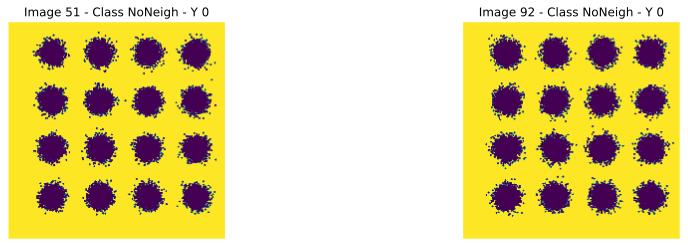

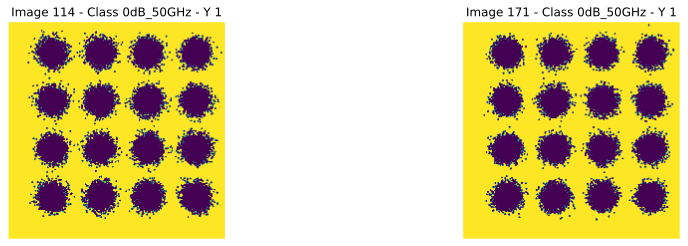

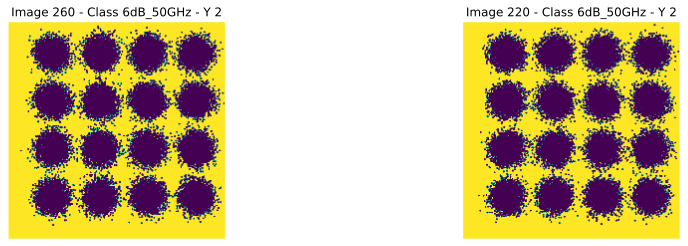

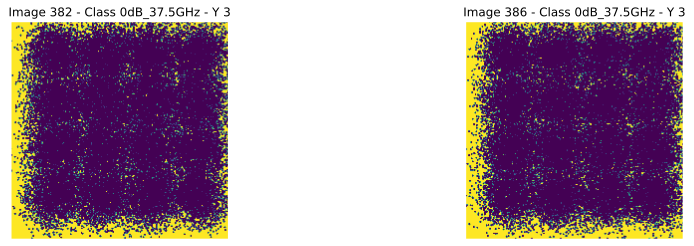

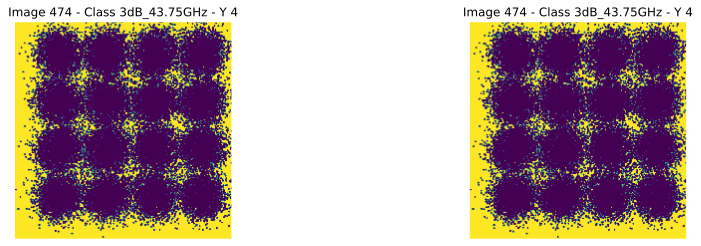

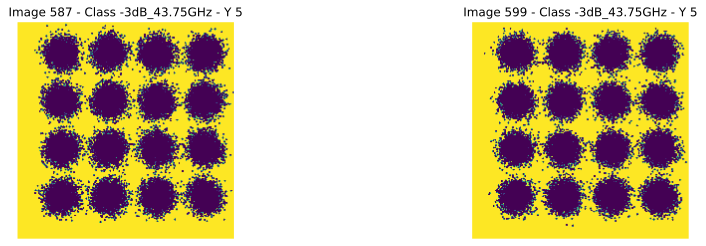

In [2]:
np.random.seed(42)

num_tests = 50 # number of random samplings from the dataset
number_outlier_samples = 10 # number of anomalous sample per sampling
normal_classes = [0, 1]

suffix = '16QAM_25dB'
anomalous_classes = [2, 3, 4, 5]
classes = ['NoNeigh',
           '0dB_50GHz',
           '6dB_50GHz',
           '0dB_37.5GHz',
           '3dB_43.75GHz',
           '-3dB_43.75GHz']
folders = ['/Results_Sq16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_NoJammingSignal/images',
           '/Results_Sq16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_50GHz/images',
           '/Results_Sq16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_6dB_Gap_50GHz/images',
           '/Results_Sq16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_0dB_Gap_37.5GHz/images',
           '/Results_Sq16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_3dB_Gap_43.75GHz/images',
           '/Results_Sq16QAM_OSNR_25dB_ChSp_50GHz_TxPower_1dBm_PwrDiff_-3dB_Gap_43.75GHz/images']

base_folder = '/nobackup/carda/datasets/ml-simulation-optical/2019-ecoc'

num_images = len(os.listdir(base_folder + folders[0]))

X = np.zeros((num_images * len(classes), 614, 614, 3))
X_grayscale = np.zeros((num_images * len(classes), 614, 614))
Y = np.zeros((num_images * len(classes)), dtype=int)

x_margin = 130
y_margin = 277

for id_class, folder in enumerate(folders):
    folder_path = base_folder + folder

    for i, file in enumerate(os.listdir(folder_path)):
        img = imageio.imread(folder_path + '/' + file)
        new_image = img[x_margin+1:img.shape[0] - x_margin, y_margin-1:img.shape[1] - y_margin, :]
        X[id_class*num_images+i, :, :, :] = new_image
        X_grayscale[id_class*num_images+i, :, :] = new_image[..., :,1]
    Y[id_class*num_images:(id_class+1)*num_images] = id_class
    
    # plotting some samples
    num_samples = 2
    samples = np.random.choice(num_images, size=num_samples)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 4))
    for i, sample in enumerate(samples):
        axs[i].imshow(X_grayscale[id_class*num_images+sample, :, :])
        axs[i].set_title('Image {} - Class {} - Y {}'.format(id_class*num_images+sample, classes[id_class], Y[id_class*num_images+sample]))
        axs[i].axis('off')
    plt.show()
    plt.close()

### Loading the autoencoder

Here, we use the same autoencoder trained for 16QAM@40dB

In [4]:
loaded= load_model('models/autoencoder.h5')
layer = len(loaded.layers) // 2
encoder = Model(loaded.input, loaded.layers[layer].output)

loaded.summary()
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 614, 614, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 614, 614, 1)       37        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 307, 307, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 307, 307, 16)      592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 154, 154, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 154, 154, 1)       577       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 52, 52, 1)         0     

### Splitting the dataset and normalizing features

In [5]:
normal_samples = X_grayscale[np.argwhere(Y <= 1)] # Y == 0 is no neighboring, and Y == 1 is channel neighboring with 0 dB and 50 GHz

x_train, x_test, y_train, y_test = train_test_split(normal_samples, Y[Y <= 1], stratify=Y[Y <= 1], test_size=0.5, random_state=42)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 614, 614, 1)) # shapes the inputs for what the encoder is expecting
x_test = x_test.reshape((len(x_test), 614, 614, 1))

x_train_encoded = encoder.predict(x_train)
shape_encoded = np.shape(x_train_encoded)
x_train_encoded = x_train_encoded.reshape(shape_encoded[0], shape_encoded[1] * shape_encoded[2]) # we need to reshape to have it in two dimensions
x_test_encoded = encoder.predict(x_test).reshape(len(x_test), shape_encoded[1] * shape_encoded[2])

print('done')

done


### Showing a few samples of the resulting encoded image

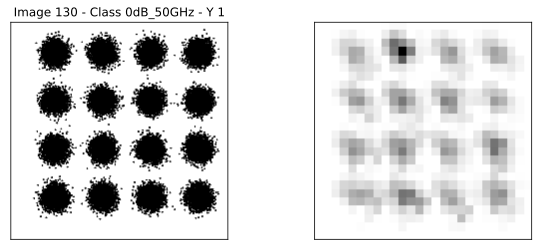

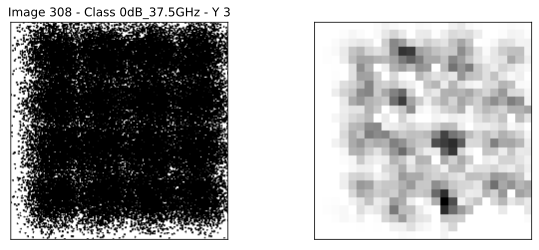

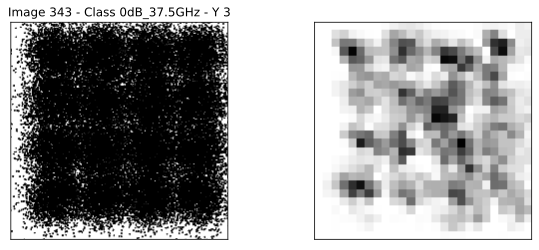

In [6]:
n = 3
for i in range(n):
    # display original
    sample = np.random.randint(0, X_grayscale.shape[0])
    plt.figure(figsize=(10, 4))
    ax = plt.subplot(1, 2, 1)
    plt.imshow(X_grayscale[sample,...].reshape(614, 614))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('Image {} - Class {} - Y {}'.format(sample, classes[Y[sample]], Y[sample]))
    
    encoded = encoder.predict(X_grayscale[sample,...].reshape(1, 614, 614, 1))

    # display reconstruction
    ax = plt.subplot(1, 2, 2)
    plt.imshow(1 - encoded.reshape(encoded.shape[1], encoded.shape[2]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    plt.savefig(f'figures/input-encoded-{suffix}-{i}.pdf')
    plt.savefig(f'figures/input-encoded-{suffix}-{i}.svg')
    plt.show()
    plt.close()

### Evaluating the performance of DBSCAN

In [7]:
epsilon_configurations = [.1, .5, 1., 1.5, 2., 2.5, 3., 4., 5., 10.]
min_samples_configurations = [1, 4, 8, 10, 12, 15, 20, 30, 40, 50]

highest_f1_encoded = 0.
highest_f1_full = 0.

performance_dbscan_full = {}
performance_dbscan_encoded = {}

for idm, min_samples in enumerate(min_samples_configurations):
    performance_dbscan_full[min_samples] = {}
    performance_dbscan_encoded[min_samples] = {}
    for ide, epsilon in enumerate(epsilon_configurations):
        performance_dbscan_full[min_samples][epsilon] = {}
        
        performance_dbscan_encoded[min_samples][epsilon] = {}

html_dbscan_encoded = '<h3>DBSCAN for encoded dataset</h3><table><tr><th>epsilon<br/>MinPts</th>'
html_dbscan_full = '<h3>DBSCAN for full dataset</h3><table><tr><th>epsilon<br/>MinPts</th>'
for ide, epsilon in enumerate(epsilon_configurations):
    html_dbscan_encoded += '<th>{}</th>'.format(epsilon)
    html_dbscan_full += '<th>{}</th>'.format(epsilon)
html_dbscan_encoded += '</tr>'
html_dbscan_full += '</tr>'

# pbar = tqdm(total=len(min_samples_configurations)*len(epsilon_configurations), desc='Number of configurations')
for idm, min_samples in enumerate(min_samples_configurations):
    html_dbscan_encoded += '<tr><th>{}</th>'.format(min_samples)
    html_dbscan_full += '<tr><th>{}</th>'.format(min_samples)
    for ide, epsilon in enumerate(epsilon_configurations):
        print(f'M: {min_samples} ({idm+1}/{len(min_samples_configurations)})\te: {epsilon} ({ide+1}/{len(epsilon_configurations)})')
        clf = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')

        true_positives = []
        false_negatives = []
        true_negatives = []
        false_positives = []
        precisions = []
        recalls = []
        f1_scores = []
        
        for t in range(num_tests):
            
            print('\tenc test', t+1, '/', num_tests)
        
            for clazz in anomalous_classes:
            
                where = np.argwhere(Y == clazz)
                outliers_indices = np.random.choice(where[:,0], size=number_outlier_samples)
                outliers = X_grayscale[outliers_indices]
                outliers = outliers.astype('float32') / 255.
                outliers = outliers.reshape(len(outliers), 614, 614, 1)
                outliers = encoder.predict(outliers).reshape(len(outliers), shape_encoded[1] * shape_encoded[2])
                x_data_test = np.concatenate((x_test_encoded, outliers), axis=0)
                y_data_test = np.concatenate((y_test, Y[where[:,0]]), axis=0)

                y_pred = clf.fit_predict(x_data_test)

                # new computation
                tpr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] == -1 and y_data_test[i] in anomalous_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in anomalous_classes])
                fnr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] >=  0 and y_data_test[i] in anomalous_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in anomalous_classes])

                tnr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] >=  0 and y_data_test[i] in normal_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in normal_classes])
                fpr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] == -1 and y_data_test[i] in normal_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in normal_classes])

                if tpr == 0: # avoids division by zero
                    precision = 0.
                    recall = 0.
                    f1 = 0.
                else:
                    precision = tpr / (tpr + fpr)
                    recall = tpr / (tpr + fnr)
                    f1 = 2 * precision * recall / (precision + recall)

                true_positives.append(tpr)
                false_negatives.append(fnr)
                true_negatives.append(tnr)
                false_positives.append(fpr)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1)
        
        performance_dbscan_encoded[min_samples][epsilon]['min_samples'] = min_samples
        performance_dbscan_encoded[min_samples][epsilon]['epsilon'] = epsilon
        performance_dbscan_encoded[min_samples][epsilon]['true_positive_rate'] = np.mean(true_positives)
        performance_dbscan_encoded[min_samples][epsilon]['false_negative_rate'] = np.mean(false_negatives)
        performance_dbscan_encoded[min_samples][epsilon]['true_negative_rate'] = np.mean(true_negatives)
        performance_dbscan_encoded[min_samples][epsilon]['false_positive_rate'] = np.mean(false_positives)
        performance_dbscan_encoded[min_samples][epsilon]['precision'] = np.mean(precisions)
        performance_dbscan_encoded[min_samples][epsilon]['recall'] = np.mean(recalls)
        performance_dbscan_encoded[min_samples][epsilon]['f1_score'] = np.mean(f1_scores)
        performance_dbscan_encoded[min_samples][epsilon]['false_positives'] = false_positives
        performance_dbscan_encoded[min_samples][epsilon]['false_negatives'] = false_negatives
        
        note = ''
        if highest_f1_encoded < np.mean(f1_scores):
            highest_f1_encoded = np.mean(f1_scores)
            note = '*'
        html_dbscan_encoded += '<td>{:.3f}, {:.3f} {}</td>'.format(np.mean(false_positives), np.mean(false_negatives), note)

        # benchmarking the full constelations
        true_positives = []
        false_negatives = []
        true_negatives = []
        false_positives = []
        precisions = []
        recalls = []
        f1_scores = []
        for t in range(num_tests):
            
            print('\tfull test', t+1, '/', num_tests)
            
            for clazz in anomalous_classes:
                
                where = np.argwhere(Y == clazz)
                outliers_indices = np.random.choice(where[:,0], size=number_outlier_samples)
                outliers = X_grayscale[outliers_indices]
                outliers = outliers.astype('float32') / 255.
                outliers = outliers.reshape(outliers.shape[0], outliers.shape[1], outliers.shape[2], 1)
                
                x_data_test = np.concatenate((x_test, outliers), axis=0)
                y_data_test = np.concatenate((y_test, Y[where[:,0]]), axis=0)
                
                y_pred = clf.fit_predict(x_data_test.reshape((x_data_test.shape[0], x_data_test.shape[1]*x_data_test.shape[2])))
                
                tpr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] == -1 and y_data_test[i] in anomalous_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in anomalous_classes])
                fnr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] >=  0 and y_data_test[i] in anomalous_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in anomalous_classes])

                tnr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] >=  0 and y_data_test[i] in normal_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in normal_classes])
                fpr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] == -1 and y_data_test[i] in normal_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in normal_classes])

                if tpr == 0: # avoids division by zero
                    precision = 0.
                    recall = 0.
                    f1 = 0.
                else:
                    precision = tpr / (tpr + fpr)
                    recall = tpr / (tpr + fnr)
                    f1 = 2 * precision * recall / (precision + recall)

                true_positives.append(tpr)
                false_negatives.append(fnr)
                true_negatives.append(tnr)
                false_positives.append(fpr)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1)
        
        performance_dbscan_full[min_samples][epsilon]['min_samples'] = min_samples
        performance_dbscan_full[min_samples][epsilon]['epsilon'] = epsilon
        performance_dbscan_full[min_samples][epsilon]['true_positive_rate'] = np.mean(true_positives)
        performance_dbscan_full[min_samples][epsilon]['false_negative_rate'] = np.mean(false_negatives)
        performance_dbscan_full[min_samples][epsilon]['true_negative_rate'] = np.mean(true_negatives)
        performance_dbscan_full[min_samples][epsilon]['false_positive_rate'] = np.mean(false_positives)
        performance_dbscan_full[min_samples][epsilon]['precision'] = np.mean(precisions)
        performance_dbscan_full[min_samples][epsilon]['recall'] = np.mean(recalls)
        performance_dbscan_full[min_samples][epsilon]['f1_score'] = np.mean(f1_scores)
        performance_dbscan_full[min_samples][epsilon]['false_positives'] = false_positives
        performance_dbscan_full[min_samples][epsilon]['false_negatives'] = false_negatives
        
        note = ''
        if highest_f1_full < np.mean(f1_scores):
            highest_f1_full = np.mean(f1_scores)
            note = '*'

        html_dbscan_full += '<td>{:.3f}, {:.3f} {}</td>'.format(np.mean(false_positives), np.mean(false_negatives), note)
        clear_output(wait=True)
        display(HTML(html_dbscan_encoded + '</tr></table>' + html_dbscan_full + '</tr></table>'))

    html_dbscan_encoded += '</tr>'
    html_dbscan_full += '</tr>'
html_dbscan_encoded += '</table>'
html_dbscan_full += '</table>'
# pbar.close()

epsilonMinPts,0.1,0.5,1.0,1.5,2.0,2.5,3.0,4.0,5.0,10.0
1,"0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000"
4,"1.000, 0.000 *","0.030, 0.156 *","0.000, 0.713","0.000, 0.783","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000"
8,"1.000, 0.000","0.030, 0.009 *","0.000, 0.610","0.000, 0.750","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000"
10,"1.000, 0.000","0.030, 0.000 *","0.000, 0.515","0.000, 0.750","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000"
12,"1.000, 0.000","0.030, 0.000","0.000, 0.500","0.000, 0.500","0.000, 0.500","0.000, 0.693","0.000, 0.750","0.000, 0.998","0.000, 1.000","0.000, 1.000"
15,"1.000, 0.000","0.030, 0.000","0.000, 0.496","0.000, 0.500","0.000, 0.500","0.000, 0.699","0.000, 0.750","0.000, 0.987","0.000, 1.000","0.000, 1.000"
20,"1.000, 0.000","0.030, 0.000","0.000, 0.479","0.000, 0.500","0.000, 0.500","0.000, 0.700","0.000, 0.748","0.000, 0.987","0.000, 1.000","0.000, 1.000"
30,"1.000, 0.000","0.040, 0.000","0.000, 0.468","0.000, 0.500","0.000, 0.500","0.000, 0.692","0.000, 0.748","0.000, 0.987","0.000, 1.000","0.000, 1.000"
40,"1.000, 0.000","0.050, 0.000","0.000, 0.470","0.000, 0.500","0.000, 0.500","0.000, 0.692","0.000, 0.748","0.000, 0.987","0.000, 1.000","0.000, 1.000"
50,"1.000, 0.000","0.500, 0.000","0.000, 0.472","0.000, 0.500","0.000, 0.500","0.000, 0.697","0.000, 0.746","0.000, 0.985","0.000, 1.000","0.000, 1.000"


epsilonMinPts,0.1,0.5,1.0,1.5,2.0,2.5,3.0,4.0,5.0,10.0
1,"0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000"
4,"1.000, 0.000 *","0.030, 0.156 *","0.000, 0.713","0.000, 0.783","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000"
8,"1.000, 0.000","0.030, 0.009 *","0.000, 0.610","0.000, 0.750","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000"
10,"1.000, 0.000","0.030, 0.000 *","0.000, 0.515","0.000, 0.750","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000","0.000, 1.000"
12,"1.000, 0.000","0.030, 0.000","0.000, 0.500","0.000, 0.500","0.000, 0.500","0.000, 0.693","0.000, 0.750","0.000, 0.998","0.000, 1.000","0.000, 1.000"
15,"1.000, 0.000","0.030, 0.000","0.000, 0.496","0.000, 0.500","0.000, 0.500","0.000, 0.699","0.000, 0.750","0.000, 0.987","0.000, 1.000","0.000, 1.000"
20,"1.000, 0.000","0.030, 0.000","0.000, 0.479","0.000, 0.500","0.000, 0.500","0.000, 0.700","0.000, 0.748","0.000, 0.987","0.000, 1.000","0.000, 1.000"
30,"1.000, 0.000","0.040, 0.000","0.000, 0.468","0.000, 0.500","0.000, 0.500","0.000, 0.692","0.000, 0.748","0.000, 0.987","0.000, 1.000","0.000, 1.000"
40,"1.000, 0.000","0.050, 0.000","0.000, 0.470","0.000, 0.500","0.000, 0.500","0.000, 0.692","0.000, 0.748","0.000, 0.987","0.000, 1.000","0.000, 1.000"
50,"1.000, 0.000","0.500, 0.000","0.000, 0.472","0.000, 0.500","0.000, 0.500","0.000, 0.697","0.000, 0.746","0.000, 0.985","0.000, 1.000","0.000, 1.000"


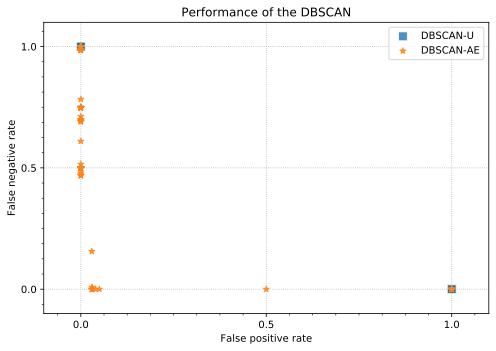

In [14]:
display(HTML(html_dbscan_encoded))

plt.figure(figsize=(7,5))

plt.scatter([performance_dbscan_full[min_samples][epsilon]['false_positive_rate'] for idm, min_samples in enumerate(performance_dbscan_full) for ide, epsilon in enumerate(performance_dbscan_full[min_samples])],
           [performance_dbscan_full[min_samples][epsilon]['false_negative_rate'] for idm, min_samples in enumerate(performance_dbscan_full) for ide, epsilon in enumerate(performance_dbscan_full[min_samples])],
           marker='s', label='DBSCAN-U', s=80, alpha=.8, edgecolors='white')

plt.scatter([performance_dbscan_encoded[min_samples][epsilon]['false_positive_rate'] for idm, min_samples in enumerate(performance_dbscan_encoded) for ide, epsilon in enumerate(performance_dbscan_encoded[min_samples])],
           [performance_dbscan_encoded[min_samples][epsilon]['false_negative_rate'] for idm, min_samples in enumerate(performance_dbscan_encoded) for ide, epsilon in enumerate(performance_dbscan_encoded[min_samples])],
           marker='*', label='DBSCAN-AE', s=40, alpha=.8)

plt.title('Performance of the DBSCAN')
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
plt.grid(True, ls=':')
plt.xticks([0, .5, 1.])
plt.xlim([-0.1, 1.1])
plt.yticks([0, .5, 1.])
plt.ylim([-0.1, 1.1])
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(8))
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(8))
# plt.gca().tick_params(which='minor', length=4)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'figures/dbscan-performance_{suffix}.pdf')
plt.savefig(f'figures/dbscan-performance_{suffix}.svg')
plt.show()
plt.close()

### Evaluating the performance of OCSVM

In [9]:
gammas = [0.001, 0.1, 0.2, 0.5, 0.7, 1.0]
kernels = ['rbf', 'linear', 'sigmoid'] # removed due to time
nus = [0.01, 0.1, .3, .5, .7, 1.]

performance_ocsvm_encoded = {}
performance_ocsvm_full = {}
for kernel in kernels:
    performance_ocsvm_encoded[kernel] = {}
    performance_ocsvm_full[kernel] = {}
    for nu in nus:
        performance_ocsvm_encoded[kernel][nu] = {}
        performance_ocsvm_full[kernel][nu] = {}
        for gamma in gammas:
            performance_ocsvm_encoded[kernel][nu][gamma] = {}
            performance_ocsvm_full[kernel][nu][gamma] = {}

html_ocsvm_encoded = '<h3>Encoded dataset</h3><table><tr><th>gamma</th>'
html_ocsvm_full = '<h3>Full dataset</h3><table><tr><th>gamma</th>'
for gamma in gammas:
    html_ocsvm_encoded += '<th>{}</th>'.format(gamma)
    html_ocsvm_full += '<th>{}</th>'.format(gamma)

html_ocsvm_encoded += '</tr>'
html_ocsvm_full += '</tr>'

for idk, kernel in enumerate(kernels):
    html_ocsvm_encoded += '<tr><th>nu</th><th colspan={}>{}</th></tr>'.format(len(gammas), kernel)
    html_ocsvm_full += '<tr><th>nu</th><th colspan={}>{}</th></tr>'.format(len(gammas), kernel)
    for idn, nu in enumerate(nus):
        html_ocsvm_encoded += '<tr><th>{}</th>'.format(nu)
        html_ocsvm_full += '<tr><th>{}</th>'.format(nu)
        for idg, gamma in enumerate(gammas):
            print(f'k: {kernel} ({idk+1}/{len(kernels)})\tnu: {nu} ({idn+1}/{len(nus)})\tgamma: {gamma} ({idg+1}/{len(gammas)})')
            # benchmarking the encoded version
            clf_encoded = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
            clf_encoded.fit(x_train_encoded)

            y_pred_train = clf_encoded.predict(x_train_encoded)
            false_positives_train = float(np.count_nonzero(y_pred_train == -1)) / float(len(x_train_encoded))
            
            true_positives = []
            false_negatives = []
            true_negatives = []
            false_positives = []
            precisions = []
            recalls = []
            f1_scores = []
            
            for t in range(num_tests):
                print('\tenc test', t+1, '/', num_tests)
                anomalous_dataset = None #np.copy(x_test_encoded)
                y_data_test = np.copy(y_test)
                for clazz in anomalous_classes:
                    where = np.argwhere(Y == clazz)
                    outliers_indices = np.random.choice(where[:,0], size=number_outlier_samples)
                    outliers = X_grayscale[outliers_indices]
                    outliers = outliers.astype('float32') / 255.
                    outliers = outliers.reshape(outliers.shape[0], outliers.shape[1], outliers.shape[2], 1)
                    if anomalous_dataset is None:
                        anomalous_dataset = outliers
                    else:
                        anomalous_dataset = np.concatenate((anomalous_dataset, outliers), axis=0)
                    y_data_test = np.concatenate((y_data_test, Y[where[:,0]]), axis=0)
                outliers = encoder.predict(anomalous_dataset).reshape(len(anomalous_dataset), shape_encoded[1] * shape_encoded[2])
                test_dataset = np.concatenate((x_test_encoded, outliers), axis=0)
                    
                y_pred = clf_encoded.predict(test_dataset)
        
                # new computation
                tpr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] == -1 and y_data_test[i] in anomalous_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in anomalous_classes])
                fnr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] ==  1 and y_data_test[i] in anomalous_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in anomalous_classes])

                tnr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] ==  1 and y_data_test[i] in normal_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in normal_classes])
                fpr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] == -1 and y_data_test[i] in normal_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in normal_classes])

                if tpr == 0: # avoids division by zero
                    precision = 0.
                    recall = 0.
                    f1 = 0.
                else:
                    precision = tpr / (tpr + fpr)
                    recall = tpr / (tpr + fnr)
                    f1 = 2 * precision * recall / (precision + recall)

                true_positives.append(tpr)
                false_negatives.append(fnr)
                true_negatives.append(tnr)
                false_positives.append(fpr)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1)
            
            performance_ocsvm_encoded[kernel][nu][gamma]['kernel'] = kernel
            performance_ocsvm_encoded[kernel][nu][gamma]['nu'] = nu
            performance_ocsvm_encoded[kernel][nu][gamma]['gamma'] = gamma
            performance_ocsvm_encoded[kernel][nu][gamma]['true_positive_rate'] = np.mean(true_positives)
            performance_ocsvm_encoded[kernel][nu][gamma]['false_negative_rate'] = np.mean(false_negatives)
            performance_ocsvm_encoded[kernel][nu][gamma]['true_negative_rate'] = np.mean(true_negatives)
            performance_ocsvm_encoded[kernel][nu][gamma]['false_positive_rate'] = np.mean(false_positives)
            performance_ocsvm_encoded[kernel][nu][gamma]['precision'] = np.mean(precisions)
            performance_ocsvm_encoded[kernel][nu][gamma]['recall'] = np.mean(recalls)
            performance_ocsvm_encoded[kernel][nu][gamma]['f1_score'] = np.mean(f1_scores)
            performance_ocsvm_encoded[kernel][nu][gamma]['false_positives'] = false_positives
            performance_ocsvm_encoded[kernel][nu][gamma]['false_negatives'] = false_negatives

            html_ocsvm_encoded += '<td>{:.3f}, {:.3f}, {:.3f}</td>'.format(false_positives_train, np.mean(false_positives), np.mean(false_negatives))
            
            # benchmarking the full dataset
            clf_full = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
            clf_full.fit(x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2])))

            y_pred_train = clf_full.predict(x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2])))
            false_positives_train = float(np.count_nonzero(y_pred_train == -1)) / float(len(x_train))
            
            true_positives = []
            false_negatives = []
            true_negatives = []
            false_positives = []
            precisions = []
            recalls = []
            f1_scores = []
            
            for t in range(num_tests):
                print('\tfull test', t+1, '/', num_tests)
                test_dataset = np.copy(x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2]))
                y_data_test = np.copy(y_test)
                for clazz in anomalous_classes:
                    where = np.argwhere(Y == clazz)
                    outliers_indices = np.random.choice(where[:,0], size=number_outlier_samples)
                    outliers = X_grayscale[outliers_indices]
                    outliers = outliers.astype('float32') / 255.
                    outliers = outliers.reshape(outliers.shape[0], outliers.shape[1] * outliers.shape[2])
                    test_dataset = np.concatenate((test_dataset, outliers), axis=0)
                    y_data_test = np.concatenate((y_data_test, Y[where[:,0]]), axis=0)
                y_pred = clf_full.predict(test_dataset)

                fpr = np.sum([1 for i in range(x_test_encoded.shape[0]) if y_pred[i] == -1]) / x_test_encoded.shape[0]

                # new computation
                tpr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] == -1 and y_data_test[i] in anomalous_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in anomalous_classes])
                fnr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] ==  1 and y_data_test[i] in anomalous_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in anomalous_classes])

                tnr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] ==  1 and y_data_test[i] in normal_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in normal_classes])
                fpr = np.sum([1 for i in range(y_pred.shape[0]) if y_pred[i] == -1 and y_data_test[i] in normal_classes]) / np.sum([1 for i in range(y_pred.shape[0]) if y_data_test[i] in normal_classes])

                if tpr == 0: # avoids division by zero
                    precision = 0.
                    recall = 0.
                    f1 = 0.
                else:
                    precision = tpr / (tpr + fpr)
                    recall = tpr / (tpr + fnr)
                    f1 = 2 * precision * recall / (precision + recall)

                true_positives.append(tpr)
                false_negatives.append(fnr)
                true_negatives.append(tnr)
                false_positives.append(fpr)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1)
            
            performance_ocsvm_full[kernel][nu][gamma]['kernel'] = kernel
            performance_ocsvm_full[kernel][nu][gamma]['nu'] = nu
            performance_ocsvm_full[kernel][nu][gamma]['gamma'] = gamma
            performance_ocsvm_full[kernel][nu][gamma]['true_positive_rate'] = np.mean(true_positives)
            performance_ocsvm_full[kernel][nu][gamma]['false_negative_rate'] = np.mean(false_negatives)
            performance_ocsvm_full[kernel][nu][gamma]['true_negative_rate'] = np.mean(true_negatives)
            performance_ocsvm_full[kernel][nu][gamma]['false_positive_rate'] = np.mean(false_positives)
            performance_ocsvm_full[kernel][nu][gamma]['precision'] = np.mean(precisions)
            performance_ocsvm_full[kernel][nu][gamma]['recall'] = np.mean(recalls)
            performance_ocsvm_full[kernel][nu][gamma]['f1_score'] = np.mean(f1_scores)
            performance_ocsvm_full[kernel][nu][gamma]['false_positives'] = false_positives
            performance_ocsvm_full[kernel][nu][gamma]['false_negatives'] = false_negatives

            html_ocsvm_full += '<td>{:.3f}, {:.3f}, {:.3f}</td>'.format(false_positives_train, np.mean(false_positives), np.mean(false_negatives))
        html_ocsvm_encoded += '</tr>'
        html_ocsvm_full += '</tr>'
html_ocsvm_encoded += '</table>'
html_ocsvm_full += '</table>'

k: rbf (1/3)	nu: 0.01 (1/6)	gamma: 0.001 (1/6)
	enc test 1 / 50
	enc test 2 / 50
	enc test 3 / 50
	enc test 4 / 50
	enc test 5 / 50
	enc test 6 / 50
	enc test 7 / 50
	enc test 8 / 50
	enc test 9 / 50
	enc test 10 / 50
	enc test 11 / 50
	enc test 12 / 50
	enc test 13 / 50
	enc test 14 / 50
	enc test 15 / 50
	enc test 16 / 50
	enc test 17 / 50
	enc test 18 / 50
	enc test 19 / 50
	enc test 20 / 50
	enc test 21 / 50
	enc test 22 / 50
	enc test 23 / 50
	enc test 24 / 50
	enc test 25 / 50
	enc test 26 / 50
	enc test 27 / 50
	enc test 28 / 50
	enc test 29 / 50
	enc test 30 / 50
	enc test 31 / 50
	enc test 32 / 50
	enc test 33 / 50
	enc test 34 / 50
	enc test 35 / 50
	enc test 36 / 50
	enc test 37 / 50
	enc test 38 / 50
	enc test 39 / 50
	enc test 40 / 50
	enc test 41 / 50
	enc test 42 / 50
	enc test 43 / 50
	enc test 44 / 50
	enc test 45 / 50
	enc test 46 / 50
	enc test 47 / 50
	enc test 48 / 50
	enc test 49 / 50
	enc test 50 / 50
	enc test 1 / 50
	enc test 2 / 50
	enc test 3 / 50
	enc test 4

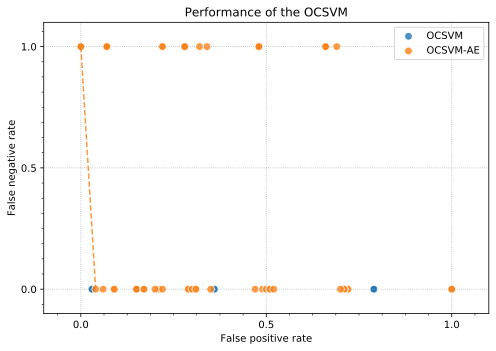

In [15]:
display(HTML(html_ocsvm_encoded))

values = sorted([[performance_ocsvm_encoded[kernel][nu][gamma]['false_positive_rate'], performance_ocsvm_encoded[kernel][nu][gamma]['false_negative_rate']] for kernel in performance_ocsvm_encoded for nu in performance_ocsvm_encoded[kernel] for gamma in performance_ocsvm_encoded[kernel][nu]], key=lambda x: x[0])

curve_fpr_encoded = []
curve_fnr_encoded = []

last_x = values[0][0]
last_y = values[0][1]

curve_fpr_encoded.append(values[0][0])
curve_fnr_encoded.append(values[0][1])

for x, y in values:
    if x > curve_fpr_encoded[-1] and y < curve_fnr_encoded[-1]:
        curve_fpr_encoded.append(x)
        curve_fnr_encoded.append(y)

values = sorted([[performance_ocsvm_full[kernel][nu][gamma]['false_positive_rate'], performance_ocsvm_full[kernel][nu][gamma]['false_negative_rate']] for kernel in performance_ocsvm_full for nu in performance_ocsvm_full[kernel] for gamma in performance_ocsvm_full[kernel][nu]], key=lambda x: x[0])

curve_fpr_full = []
curve_fnr_full = []

last_x = values[0][0]
last_y = values[0][1]

curve_fpr_full.append(values[0][0])
curve_fnr_full.append(values[0][1])

for x, y in values:
    if x > curve_fpr_full[-1] and y < curve_fnr_full[-1]:
        curve_fpr_full.append(x)
        curve_fnr_full.append(y)

plt.figure(figsize=(7,5))

ax = plt.scatter([performance_ocsvm_full[kernel][nu][gamma]['false_positive_rate'] for kernel in performance_ocsvm_full for nu in performance_ocsvm_full[kernel] for gamma in performance_ocsvm_full[kernel][nu]], 
             [performance_ocsvm_full[kernel][nu][gamma]['false_negative_rate'] for kernel in performance_ocsvm_full for nu in performance_ocsvm_full[kernel] for gamma in performance_ocsvm_full[kernel][nu]],
           marker='o', label='OCSVM', s=60, alpha=.8, edgecolors='white')
plt.plot(curve_fpr_full, curve_fnr_full, ls='--', color=ax.get_facecolors()[0])

ax = plt.scatter([performance_ocsvm_encoded[kernel][nu][gamma]['false_positive_rate'] for kernel in performance_ocsvm_encoded for nu in performance_ocsvm_encoded[kernel] for gamma in performance_ocsvm_encoded[kernel][nu]], 
             [performance_ocsvm_encoded[kernel][nu][gamma]['false_negative_rate'] for kernel in performance_ocsvm_encoded for nu in performance_ocsvm_encoded[kernel] for gamma in performance_ocsvm_encoded[kernel][nu]],
           marker='o', label='OCSVM-AE', s=60, alpha=.8, edgecolors='white')
plt.plot(curve_fpr_encoded, curve_fnr_encoded, ls='--', color=ax.get_facecolors()[0])

plt.title('Performance of the OCSVM')
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
plt.grid(True, ls=':')
plt.xticks([0, .5, 1.])
plt.xlim([-0.1, 1.1])
plt.yticks([0, .5, 1.])
plt.ylim([-0.1, 1.1])
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(8))
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(8))
# plt.gca().tick_params(which='minor', length=4)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'figures/ocsvm-performance_{suffix}.pdf')
plt.savefig(f'figures/ocsvm-performance_{suffix}.svg')
plt.show()
plt.close()

### Visualizing the performance of all models

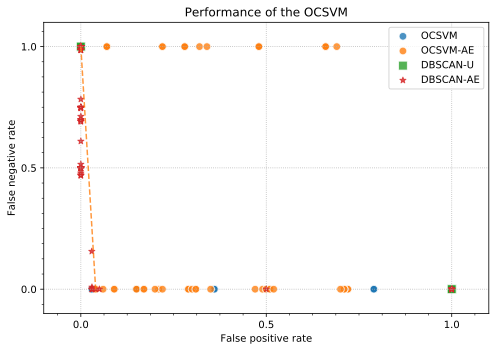

In [16]:
display(HTML(html_ocsvm_encoded))

values = sorted([[performance_ocsvm_encoded[kernel][nu][gamma]['false_positive_rate'], performance_ocsvm_encoded[kernel][nu][gamma]['false_negative_rate']] for kernel in performance_ocsvm_encoded for nu in performance_ocsvm_encoded[kernel] for gamma in performance_ocsvm_encoded[kernel][nu]], key=lambda x: x[0])

curve_fpr_encoded = []
curve_fnr_encoded = []

last_x = values[0][0]
last_y = values[0][1]

curve_fpr_encoded.append(values[0][0])
curve_fnr_encoded.append(values[0][1])

for x, y in values:
    if x > curve_fpr_encoded[-1] and y < curve_fnr_encoded[-1]:
        curve_fpr_encoded.append(x)
        curve_fnr_encoded.append(y)

values = sorted([[performance_ocsvm_full[kernel][nu][gamma]['false_positive_rate'], performance_ocsvm_full[kernel][nu][gamma]['false_negative_rate']] for kernel in performance_ocsvm_full for nu in performance_ocsvm_full[kernel] for gamma in performance_ocsvm_full[kernel][nu]], key=lambda x: x[0])

curve_fpr_full = []
curve_fnr_full = []

last_x = values[0][0]
last_y = values[0][1]

curve_fpr_full.append(values[0][0])
curve_fnr_full.append(values[0][1])

for x, y in values:
    if x > curve_fpr_full[-1] and y < curve_fnr_full[-1]:
        curve_fpr_full.append(x)
        curve_fnr_full.append(y)

plt.figure(figsize=(7,5))

ax = plt.scatter([performance_ocsvm_full[kernel][nu][gamma]['false_positive_rate'] for kernel in performance_ocsvm_full for nu in performance_ocsvm_full[kernel] for gamma in performance_ocsvm_full[kernel][nu]], 
             [performance_ocsvm_full[kernel][nu][gamma]['false_negative_rate'] for kernel in performance_ocsvm_full for nu in performance_ocsvm_full[kernel] for gamma in performance_ocsvm_full[kernel][nu]],
           marker='o', label='OCSVM', s=60, alpha=.8, edgecolors='white')
plt.plot(curve_fpr_full, curve_fnr_full, ls='--', color=ax.get_facecolors()[0])

ax = plt.scatter([performance_ocsvm_encoded[kernel][nu][gamma]['false_positive_rate'] for kernel in performance_ocsvm_encoded for nu in performance_ocsvm_encoded[kernel] for gamma in performance_ocsvm_encoded[kernel][nu]], 
             [performance_ocsvm_encoded[kernel][nu][gamma]['false_negative_rate'] for kernel in performance_ocsvm_encoded for nu in performance_ocsvm_encoded[kernel] for gamma in performance_ocsvm_encoded[kernel][nu]],
           marker='o', label='OCSVM-AE', s=60, alpha=.8, edgecolors='white')
plt.plot(curve_fpr_encoded, curve_fnr_encoded, ls='--', color=ax.get_facecolors()[0])

plt.scatter([performance_dbscan_full[min_samples][epsilon]['false_positive_rate'] for idm, min_samples in enumerate(performance_dbscan_full) for ide, epsilon in enumerate(performance_dbscan_full[min_samples])],
           [performance_dbscan_full[min_samples][epsilon]['false_negative_rate'] for idm, min_samples in enumerate(performance_dbscan_full) for ide, epsilon in enumerate(performance_dbscan_full[min_samples])],
           marker='s', label='DBSCAN-U', s=80, alpha=.8, edgecolors='white')

plt.scatter([performance_dbscan_encoded[min_samples][epsilon]['false_positive_rate'] for idm, min_samples in enumerate(performance_dbscan_encoded) for ide, epsilon in enumerate(performance_dbscan_encoded[min_samples])],
           [performance_dbscan_encoded[min_samples][epsilon]['false_negative_rate'] for idm, min_samples in enumerate(performance_dbscan_encoded) for ide, epsilon in enumerate(performance_dbscan_encoded[min_samples])],
           marker='*', label='DBSCAN-AE', s=40, alpha=.8)

plt.title('Performance of the OCSVM')
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
plt.grid(True, ls=':')
plt.xticks([0, .5, 1.])
plt.xlim([-0.1, 1.1])
plt.yticks([0, .5, 1.])
plt.ylim([-0.1, 1.1])
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(8))
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(8))
# plt.gca().tick_params(which='minor', length=4)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'figures/overall-performance_{suffix}.pdf')
plt.savefig(f'figures/overall-performance_{suffix}.svg')
plt.show()
plt.close()

### Saving performance results

In [13]:
with open(f'models/performance-metrics_{suffix}.h5', 'wb') as f:
    pickle.dump({'performance_dbscan_full': performance_dbscan_full,
                'performance_dbscan_encoded': performance_dbscan_encoded,
                 'performance_ocsvm_full': performance_ocsvm_full,
                 'performance_ocsvm_encoded': performance_ocsvm_encoded,
                 'html_ocsvm_encoded':html_ocsvm_encoded,
                 'html_ocsvm_full': html_ocsvm_full,
                 'html_dbscan_encoded': html_dbscan_encoded,
                 'html_dbscan_full': html_dbscan_full
                }, f)

###### 